In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

In [87]:
pop_df = pd.read_csv('pop_genres_dataset.csv')

print(f"Dataset shape: {pop_df.shape}")
print(f"\nGenre distribution:")
print(pop_df['track_genre'].value_counts())

pop_df.head()

Dataset shape: (9000, 18)

Genre distribution:
track_genre
cantopop     1000
indie-pop    1000
j-pop        1000
k-pop        1000
mandopop     1000
pop-film     1000
pop          1000
power-pop    1000
synth-pop    1000
Name: count, dtype: int64


,artists,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,my little airport,每次你走的時分,47,183968,0,0.576,0.505,11,-13.070,0,0.0392,0.753,0.199000,0.151,0.570,127.025,4,cantopop
1,my little airport,下了兩天雨,44,172343,0,0.577,0.228,11,-14.684,1,0.0306,0.834,0.000805,0.384,0.161,119.035,4,cantopop
2,my little airport,詩歌舞街,50,191308,0,0.641,0.479,4,-15.395,1,0.0443,0.732,0.059800,0.115,0.301,121.974,4,cantopop
3,my little airport,那陣時不知道,48,148564,0,0.613,0.210,5,-15.309,1,0.0309,0.769,0.000477,0.139,0.268,132.035,4,cantopop
4,Eason Chan,無條件,54,228973,0,0.646,0.370,0,-10.980,1,0.0351,0.825,0.000005,0.090,0.465,129.914,4,cantopop


From PCA, we decided to use 5 key features (energy, acousticness, valence, loudness, danceability) to predict the pop genre category.

In [88]:
key_features = ['energy', 'acousticness', 'valence', 'loudness', 'danceability']

X = pop_df[key_features].values
y = pop_df['track_genre'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")
print(f"\nNumber of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

Features shape: (9000, 5)
Target shape: (9000,)

Number of classes: 9
Classes: ['cantopop' 'indie-pop' 'j-pop' 'k-pop' 'mandopop' 'pop' 'pop-film'
 'power-pop' 'synth-pop']


In [89]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

num_classes = len(label_encoder.classes_)

print(f"\nStandardized features shape: {X_train_scaled.shape}")
print(f"Tensor shape: {X_train_tensor.shape}")

Training set size: 5400
Validation set size: 1800
Test set size: 1800

Standardized features shape: (5400, 5)
Tensor shape: torch.Size([5400, 5])


In [90]:
# Build a single-layer neural network following PyTorch format
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.layer = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        return self.layer(x)

# Initialize the model
model = SimpleNN(input_size=5, num_classes=num_classes)

# Compile the model
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Display model architecture
print(model)

SimpleNN(
  (layer): Linear(in_features=5, out_features=9, bias=True)
)


In [91]:
# Training loop
epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    train_loss = loss_fn(outputs, y_train_tensor)
    
    # Backward pass
    train_loss.backward()
    optimizer.step()
    
    # Calculate training accuracy
    _, train_predicted = torch.max(outputs, 1)
    train_acc = (train_predicted == y_train_tensor).sum().item() / len(y_train_tensor)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = loss_fn(val_outputs, y_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_acc = (val_predicted == y_val_tensor).sum().item() / len(y_val_tensor)
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch [10/100], Train Loss: 2.5093, Val Loss: 2.5262, Train Acc: 0.0598, Val Acc: 0.0578
Epoch [20/100], Train Loss: 2.4821, Val Loss: 2.4985, Train Acc: 0.0609, Val Acc: 0.0578
Epoch [30/100], Train Loss: 2.4561, Val Loss: 2.4720, Train Acc: 0.0615, Val Acc: 0.0578
Epoch [40/100], Train Loss: 2.4314, Val Loss: 2.4469, Train Acc: 0.0615, Val Acc: 0.0583
Epoch [50/100], Train Loss: 2.4081, Val Loss: 2.4231, Train Acc: 0.0622, Val Acc: 0.0600
Epoch [60/100], Train Loss: 2.3859, Val Loss: 2.4005, Train Acc: 0.0639, Val Acc: 0.0611
Epoch [70/100], Train Loss: 2.3649, Val Loss: 2.3790, Train Acc: 0.0654, Val Acc: 0.0628
Epoch [80/100], Train Loss: 2.3449, Val Loss: 2.3585, Train Acc: 0.0665, Val Acc: 0.0656
Epoch [90/100], Train Loss: 2.3259, Val Loss: 2.3390, Train Acc: 0.0706, Val Acc: 0.0667
Epoch [100/100], Train Loss: 2.3078, Val Loss: 2.3204, Train Acc: 0.0731, Val Acc: 0.0722


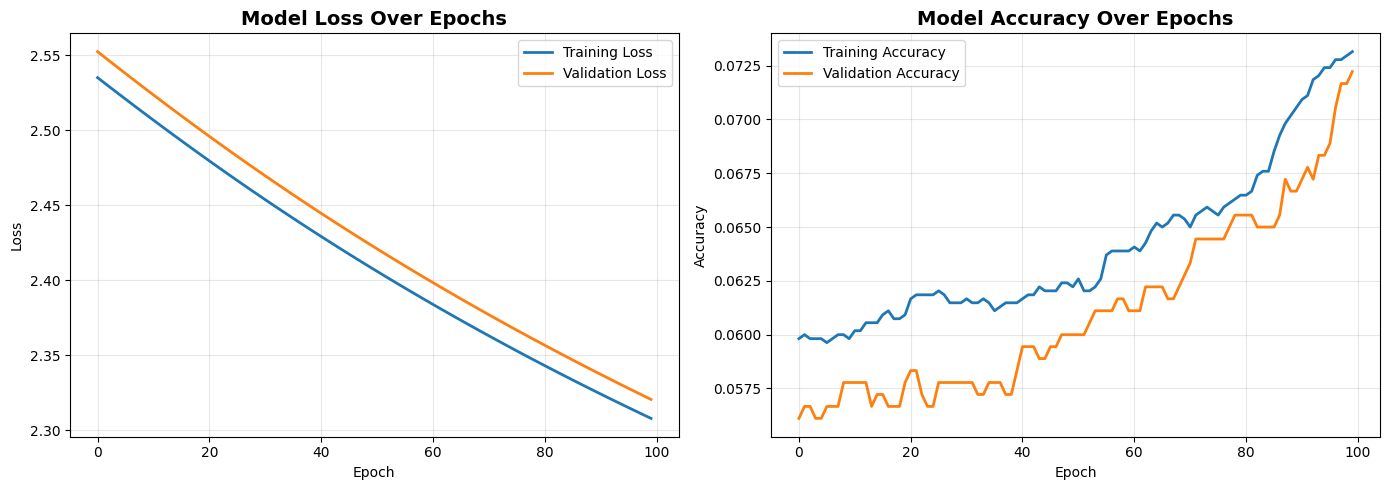

In [92]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy plot
axes[1].plot(train_accuracies, label='Training Accuracy', linewidth=2)
axes[1].plot(val_accuracies, label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [93]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = loss_fn(test_outputs, y_test_tensor)
    _, y_pred = torch.max(test_outputs, 1)
    test_acc = (y_pred == y_test_tensor).sum().item() / len(y_test_tensor)

print(f"Test Loss: {test_loss.item():.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Convert to numpy for sklearn metrics
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Classification report
print("\nClassification Report:")
print("="*70)
print(classification_report(y_test_np, y_pred_np, target_names=label_encoder.classes_))

Test Loss: 2.3242
Test Accuracy: 0.0656

Classification Report:
              precision    recall  f1-score   support

    cantopop       0.13      0.04      0.07       200
   indie-pop       0.08      0.01      0.03       200
       j-pop       0.06      0.11      0.07       200
       k-pop       0.09      0.15      0.11       200
    mandopop       0.04      0.13      0.06       200
         pop       0.00      0.00      0.00       200
    pop-film       0.18      0.07      0.10       200
   power-pop       0.00      0.00      0.00       200
   synth-pop       0.09      0.07      0.08       200

    accuracy                           0.07      1800
   macro avg       0.07      0.07      0.06      1800
weighted avg       0.07      0.07      0.06      1800



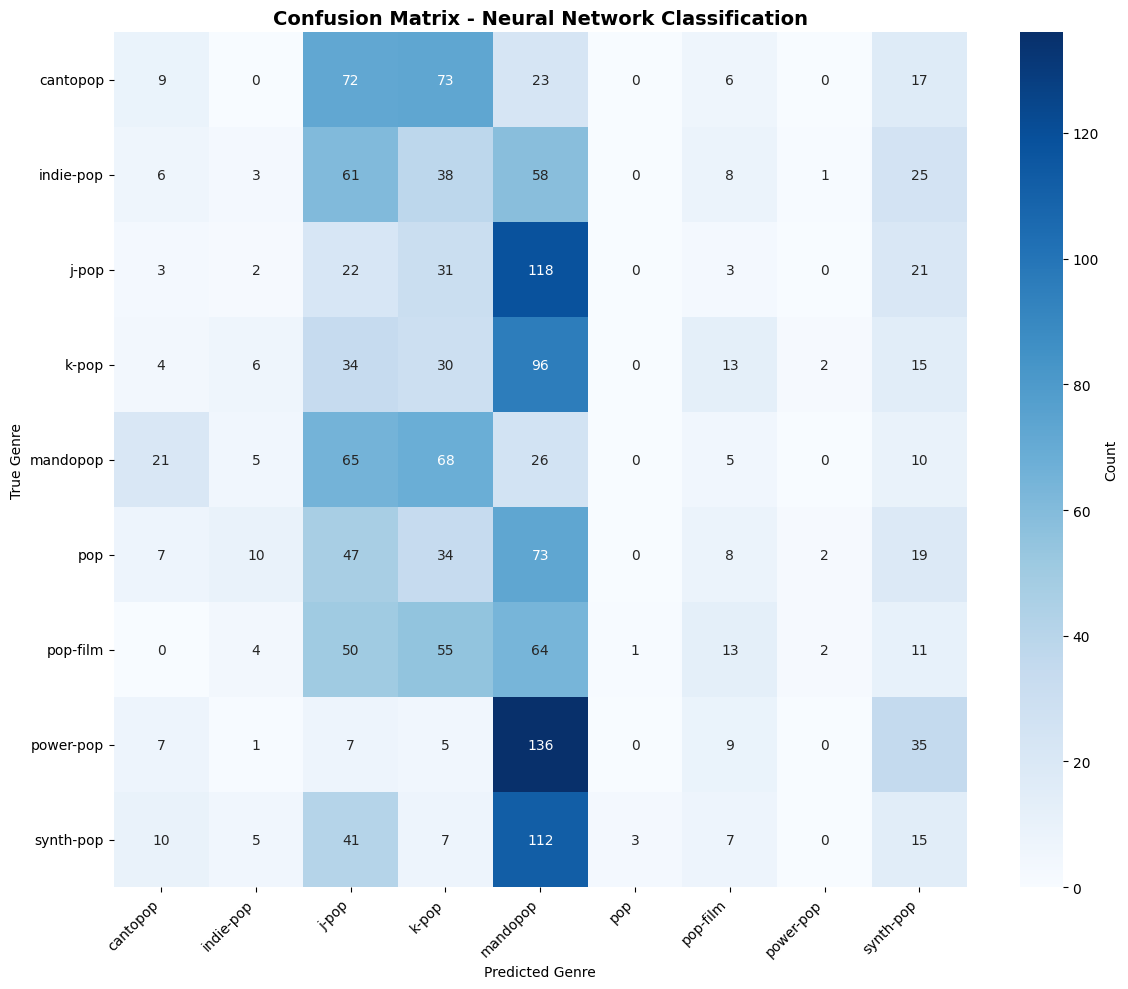

In [94]:
# Create confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Neural Network Classification', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Feature Importance (Permutation-based):
     Feature  Importance
acousticness    0.000556
     valence   -0.003333
danceability   -0.010556
    loudness   -0.017222
      energy   -0.029444


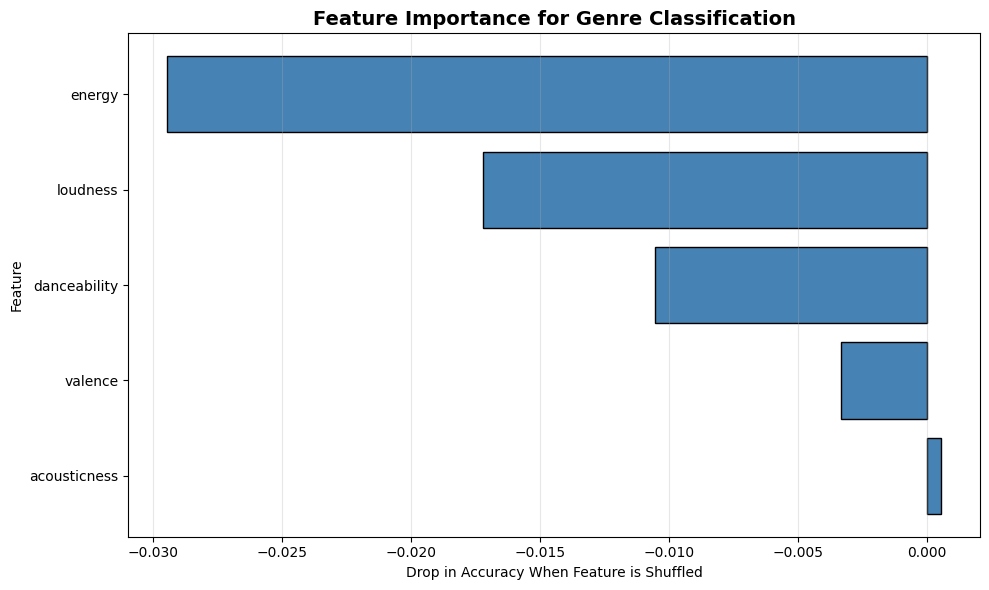

In [95]:
# Calculate permutation importance
baseline_accuracy = accuracy_score(y_test_np, y_pred_np)
feature_importance = {}

for i, feature in enumerate(key_features):
    # Create a copy of test data
    X_test_permuted = X_test_tensor.clone()
    
    # Shuffle the feature column
    torch.manual_seed(42)
    X_test_permuted[:, i] = X_test_permuted[torch.randperm(X_test_permuted.size(0)), i]
    
    # Make predictions with permuted feature
    model.eval()
    with torch.no_grad():
        outputs_permuted = model(X_test_permuted)
        _, y_pred_permuted = torch.max(outputs_permuted, 1)
    
    permuted_accuracy = accuracy_score(y_test_np, y_pred_permuted.numpy())
    
    # Calculate importance as drop in accuracy
    importance = baseline_accuracy - permuted_accuracy
    feature_importance[feature] = importance

# Sort and display
importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
}).sort_values('Importance', ascending=False)

print("Feature Importance (Permutation-based):")
print("="*50)
print(importance_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue', edgecolor='black')
plt.title('Feature Importance for Genre Classification', fontsize=14, fontweight='bold')
plt.xlabel('Drop in Accuracy When Feature is Shuffled')
plt.ylabel('Feature')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Summary

The neural network classifier uses the 5 key features (energy, acousticness, valence, loudness, danceability) to predict pop genre categories. The model architecture includes:
- Input layer: 5 features
- Hidden layers: 64 → 32 → 16 neurons with ReLU activation
- Dropout layers for regularization
- Output layer: Softmax activation for multi-class classification

The permutation importance analysis shows which features are most critical for distinguishing between different pop genres.

In [96]:
# Analyze feature statistics across genres
print("\nFeature Statistics by Genre:")
print("="*70)

feature_stats = pop_df.groupby('track_genre')[key_features].agg(['mean', 'std'])
print(feature_stats.round(3))


Feature Statistics by Genre:
            energy        acousticness        valence        loudness         \
              mean    std         mean    std    mean    std     mean    std   
track_genre                                                                    
cantopop     0.462  0.163        0.536  0.263   0.394  0.179   -9.667  3.084   
indie-pop    0.561  0.194        0.372  0.308   0.461  0.212   -7.997  3.080   
j-pop        0.680  0.240        0.282  0.306   0.542  0.213   -6.280  3.558   
k-pop        0.676  0.176        0.293  0.281   0.557  0.203   -6.471  2.922   
mandopop     0.498  0.165        0.480  0.283   0.350  0.173   -8.177  2.679   
pop          0.606  0.178        0.344  0.286   0.506  0.212   -6.954  2.563   
pop-film     0.605  0.180        0.441  0.262   0.529  0.210   -7.872  2.775   
power-pop    0.802  0.178        0.086  0.167   0.615  0.211   -6.676  3.066   
synth-pop    0.713  0.174        0.152  0.191   0.586  0.256   -8.205  3.150   

         

In [97]:
# Additional Analysis: Per-genre performance
print("Per-Genre Performance Analysis:")
print("="*70)

genre_names = label_encoder.classes_
for i, genre in enumerate(genre_names):
    genre_mask = y_test_np == i
    genre_predictions = y_pred_np[genre_mask]
    genre_correct = (genre_predictions == i).sum()
    genre_total = genre_mask.sum()
    genre_accuracy = genre_correct / genre_total if genre_total > 0 else 0
    
    print(f"{genre:15s}: {genre_correct:3d}/{genre_total:3d} correct ({genre_accuracy*100:5.1f}%)")

print("\n" + "="*70)
print(f"Overall Test Accuracy: {test_acc*100:.2f}%")
print(f"Random Baseline (1/{num_classes}): {100/num_classes:.2f}%")

Per-Genre Performance Analysis:
cantopop       :   9/200 correct (  4.5%)
indie-pop      :   3/200 correct (  1.5%)
j-pop          :  22/200 correct ( 11.0%)
k-pop          :  30/200 correct ( 15.0%)
mandopop       :  26/200 correct ( 13.0%)
pop            :   0/200 correct (  0.0%)
pop-film       :  13/200 correct (  6.5%)
power-pop      :   0/200 correct (  0.0%)
synth-pop      :  15/200 correct (  7.5%)

Overall Test Accuracy: 6.56%
Random Baseline (1/9): 11.11%


Test Accuracy was only 6.56% (really bad) because random guessing should be around 11.1% accuracy, so this model is performing worse than random guessing and probably not helpful for the model we want. (also really bad fit scores, and some genres are never even guessed). We Would need to add more features or layers to improve model.